In [1]:
%load_ext lab_black

# Project objective: Demand forecast (unit sales) for potential new products for "The Brand"

**Notebook objective:**
- Problem formulation
- Split out test
- Target and feature EDA

In [2]:
%cd ~\OneDrive\Documents\thebrand

C:\Users\igari\OneDrive\Documents\thebrand


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split

from src.utils.constants import TARGET

In [4]:
pd.options.display.float_format = "{:.4f}".format
pd.set_option("display.max_columns", 99)
pd.set_option("display.max_rows", 99)
pd.set_option("display.max_colwidth", 199)

In [5]:
base_dir = Path("/Users/igari/OneDrive/Documents/thebrand")
data = base_dir / "data"

# Reading in cleaned data

In [6]:
input_path = data / "01_raw" / "src.csv"
df = pd.read_parquet(input_path)
df.shape

(60288, 11)

In [7]:
df.describe()

,PRODUCT_TYPES,BUSINESS_SEGMENTS,NRF_COLOR_CODE,Units_sold,Searches,Social_References
count,60288.0000,60288.0000,60288.0000,60288.0000,60288.0000,60288.0000
mean,59.7115,3261161.8429,199.0292,74.3728,148.8152,30.8214
std,85.7204,12011231.4984,254.9561,38.8283,80.3762,23.2849
min,1.0000,822.0000,1.0000,12.0000,19.0000,2.0000
25%,1.0000,30305.0000,1.0000,36.0000,81.0000,14.0000
50%,16.0000,303030.0000,100.0000,72.0000,145.0000,25.0000
75%,73.0000,975534.0000,400.0000,108.0000,212.0000,44.0000
max,505.0000,97534975.0000,998.0000,204.0000,488.0000,257.0000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60288 entries, 0 to 60670
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Article                60288 non-null  object  
 1   MATERIAL_CONTENT_CODE  60288 non-null  category
 2   PRODUCT_TYPES          60288 non-null  float64 
 3   BUSINESS_SEGMENTS      60288 non-null  float64 
 4   NRF_COLOR_CODE         60288 non-null  float64 
 5   MODEL                  60287 non-null  object  
 6   Sustainablity          60288 non-null  category
 7   MARKETING_CATEGORY     60288 non-null  category
 8   Units_sold             60288 non-null  int64   
 9   Searches               60288 non-null  int64   
 10  Social_References      60288 non-null  int64   
dtypes: category(3), float64(3), int64(3), object(2)
memory usage: 4.6+ MB


# Problem formulation

This demand forecasting is clearly a regression problem.

**Input data and prediction timeframes** 
<br/>The time period of unit sales of input data is not given and it is not clear that what time period is the prediction required for. Generally, very long-term forecasts are not accurate so let us assume that the given data is for first quarter of launch and we have to also predict the unit sales for first quarter of launch.

**Other model caveats**
</br>As a result of such a formulation, the model will not work in some cases:
- There is no historical article similar to the potential new (test) article
- If a black swan event like COVID-19 has occured in the test period then model will need to be adjusted 
- If there are any website display changes or changes in marketing strategy then the results of the model will not be reliable
- If there are other product launches or ongoing events in parallel on the website then the results of the model will not be reliable
- The cannibalisation effects (both on the new products, and by the new products) are not taken into account in the MVP as this is no easy task. Cannibalization is a very subtle interaction of relative pricing, inventory levels, etc.

**Target** 
<br> In order to predict demand, we should directly predict units sold as that is directly actionable.
<br> We can safely ignore searches and social references for now.

**Predictors**
<br> In order to predict units sold for a new article, we can build a regression model with article attributes. Therefore, let us first remove the unnecessary columns, viz. article and model as they are ID features and should not be used in the model.

# Keeping test data aside 

Assuming that the `MODEL` feature in the data corresponds to an actual model i.e. a bunch of articles with color variations, then a model would be a whole new product. As a result,  the train and test split should not lead to articles of the same model getting into both dataframes.

In [9]:
df = df[~df.MODEL.isna()]

In [10]:
# Creating a dataframe with model id and its count of articles.
# Later we will use this dataframe to tag models that should fall into train or test data based on 80/20 (train/test) distribution of rows
model_df = pd.DataFrame(df.MODEL.value_counts())
model_df["Model_ID"] = model_df.index
model_df = model_df.reset_index(drop=True)
model_df.head()

,MODEL,Model_ID
0,222,DVF21
1,112,DBB20
2,96,DVF22
3,94,DBB22
4,91,EPD53


In [11]:
total_rows = model_df.MODEL.sum()
model_df_shuffled = model_df.sample(frac=1)
model_df_shuffled["split_id"] = "test"

train_sum = 0

for row in range(0, len(model_df_shuffled)):
    train_sum = train_sum + model_df_shuffled.iloc[row, 0]
    model_df_shuffled.iloc[row, 2] = "train"
    if train_sum > total_rows * 0.8:
        break

print(train_sum / df.shape[0])

0.8000398095775209


In [12]:
# Merge the split id to original df dataframe and use that to create our raw test and train dataframes
model_df_shuffled = model_df_shuffled[["Model_ID", "split_id"]]
df = df.merge(model_df_shuffled, left_on="MODEL", right_on="Model_ID")

train = df[df["split_id"] == "train"]
test = df[df["split_id"] == "test"]
print(train.shape, test.shape)

(48232, 13) (12055, 13)


In [13]:
# Dropping unnecessary columns from both test and train sets
test.drop(
    columns=[
        "Article",
        "MODEL",
        "Searches",
        "Social_References",
        "Model_ID",
        "split_id",
    ],
    inplace=True,
)
train.drop(
    columns=[
        "Article",
        "MODEL",
        "Searches",
        "Social_References",
        "Model_ID",
        "split_id",
    ],
    inplace=True,
)

train.head()

c:\users\igari\anaconda3\envs\brand\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,MATERIAL_CONTENT_CODE,PRODUCT_TYPES,BUSINESS_SEGMENTS,NRF_COLOR_CODE,Sustainablity,MARKETING_CATEGORY,Units_sold
6,AT2E,1.0000,3030975.0000,1.0000,Organic materials,2115,36
7,DO0S,39.0000,303034.0000,610.0000,Recycled,211,120
8,TRK4,13.0000,975342.0000,610.0000,PFC free,2112,120
9,AT4M,1.0000,3030975.0000,307.0000,Primeblue nylon,216,96
10,AT2P,106.0000,9759758.0000,1.0000,Recycled,211,108


<AxesSubplot:xlabel='Units_sold', ylabel='Count'>

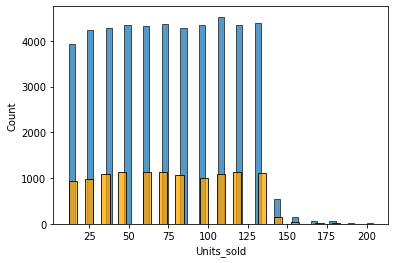

In [14]:
# Comparing the distribution of target feature in train and test dataframes
sns.histplot(data=train, x=TARGET)
sns.histplot(data=test, x=TARGET, color="orange")

The test set does have some extreme values but this can be tuned later.

In [15]:
output_test_path = data / "01_raw" / "test_raw.csv"
output_train_path = data / "01_raw" / "train_raw.csv"

test.to_parquet(output_test_path, index=None)
train.to_parquet(output_train_path, index=None)

# Exploring the target 

<AxesSubplot:xlabel='Units_sold'>

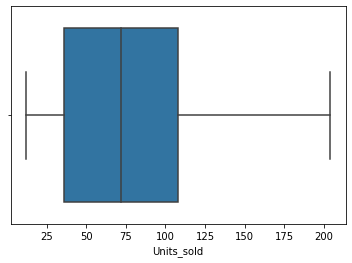

In [16]:
sns.boxplot(data=train, x=TARGET)

<AxesSubplot:xlabel='Units_sold', ylabel='Count'>

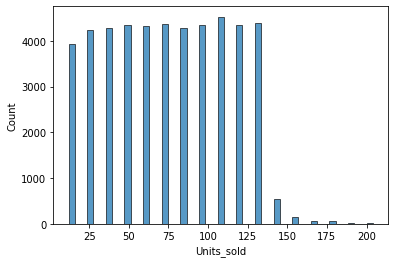

In [17]:
sns.histplot(data=train, x=TARGET)

<AxesSubplot:xlabel='Units_sold', ylabel='Count'>

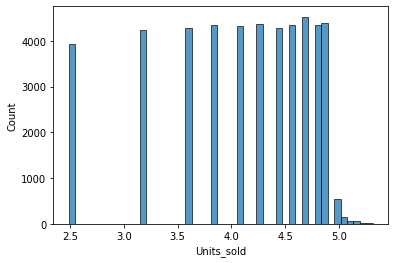

In [18]:
# What if we take a log transform?
sns.histplot(data=train, x=np.log(train[TARGET]))

The target distribution is not so normal but whether this needs to be improved, depends on the algorithm we will use. So let us leave this as a possible improvement for later.

# All of our initial features are categorical features and mostly with high cardinality. This is a challenge.

<AxesSubplot:xlabel='PRODUCT_TYPES', ylabel='Units_sold'>

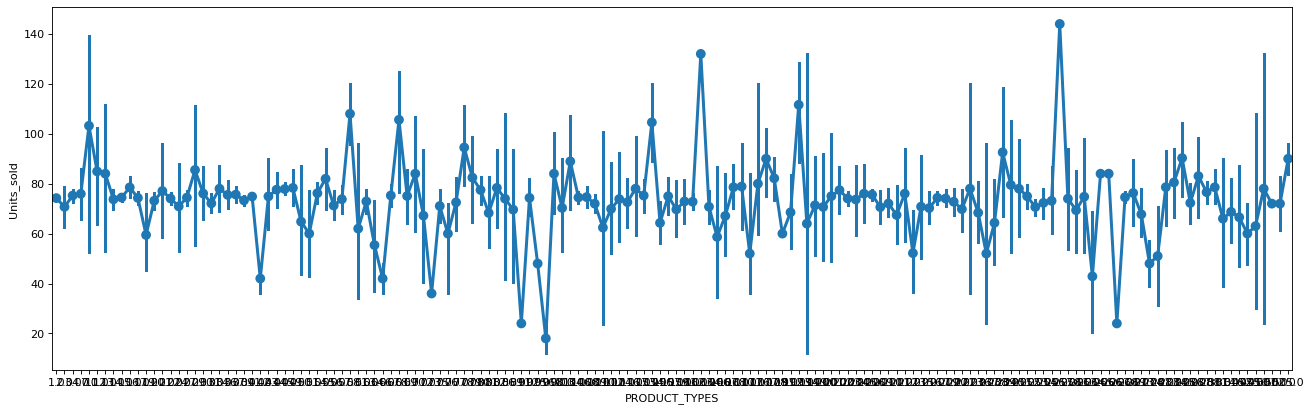

In [19]:
plt.figure(figsize=(20, 6), dpi=80)
sns.pointplot(data=train, x="PRODUCT_TYPES", y=TARGET, estimator=np.mean)

<AxesSubplot:xlabel='MATERIAL_CONTENT_CODE', ylabel='Units_sold'>

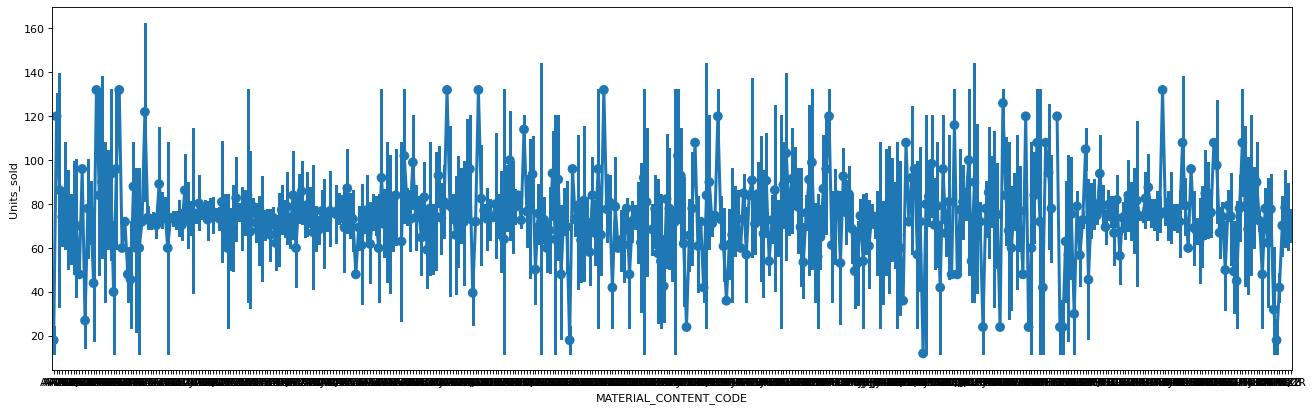

In [20]:
plt.figure(figsize=(20, 6), dpi=80)
sns.pointplot(data=train, x="MATERIAL_CONTENT_CODE", y=TARGET, estimator=np.mean)

<AxesSubplot:xlabel='BUSINESS_SEGMENTS', ylabel='Units_sold'>

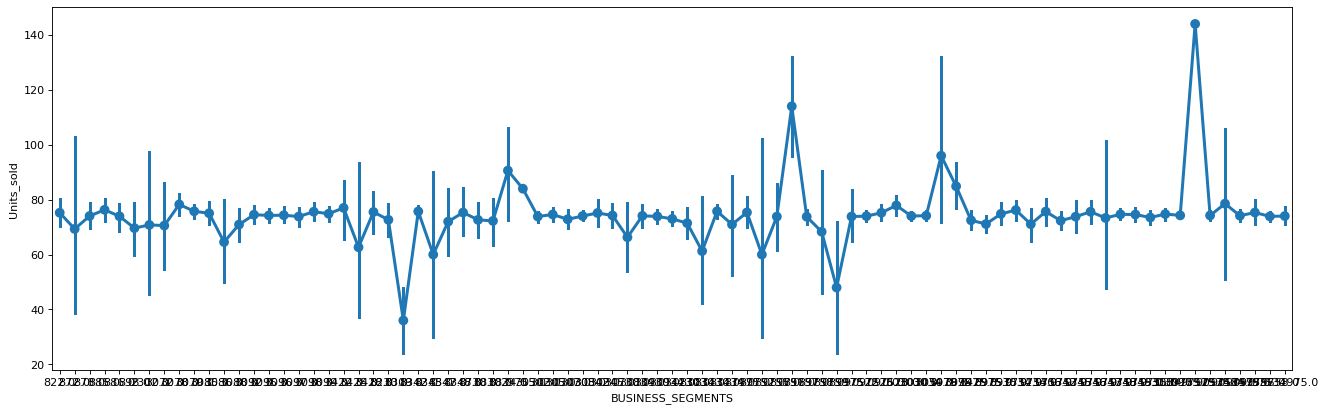

In [21]:
plt.figure(figsize=(20, 6), dpi=80)
sns.pointplot(data=train, x="BUSINESS_SEGMENTS", y=TARGET, estimator=np.mean)

<AxesSubplot:xlabel='NRF_COLOR_CODE', ylabel='Units_sold'>

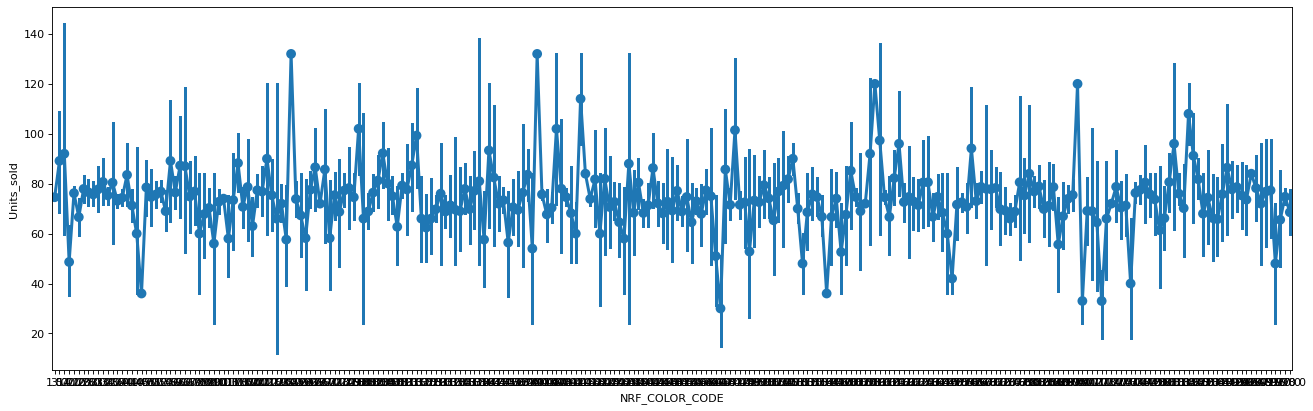

In [22]:
plt.figure(figsize=(20, 6), dpi=80)
sns.pointplot(data=train, x="NRF_COLOR_CODE", y=TARGET, estimator=np.mean)

<AxesSubplot:xlabel='Sustainablity', ylabel='Units_sold'>

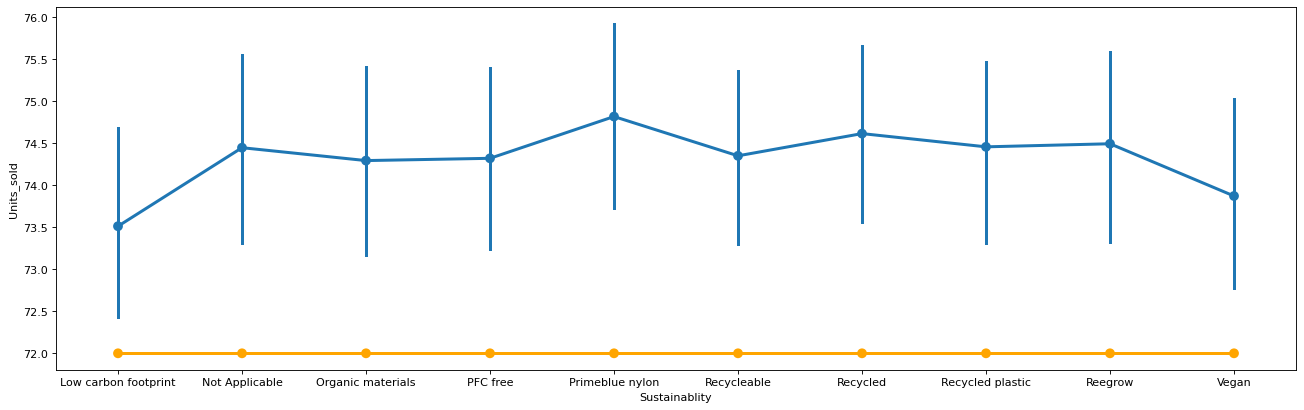

In [23]:
plt.figure(figsize=(20, 6), dpi=80)
sns.pointplot(data=train, x="Sustainablity", y=TARGET, estimator=np.mean)
sns.pointplot(
    data=train, x="Sustainablity", y=TARGET, estimator=np.median, color="orange"
)

In [ ]:
plt.figure(figsize=(20, 6), dpi=80)
sns.pointplot(data=train, x="MARKETING_CATEGORY", y=TARGET, estimator=np.mean)

All these features clearly affect the target. Also, we cannot discount the interaction effects of these features on unit sales.